In [1]:
from splender.image2 import SplenderImage
import jax.random as random
from jax import vmap, value_and_grad, grad, jit
from interpax import Interpolator1D
from functools import partial

import numpy as np
import jax
import jax.numpy as jnp
from minimum_spanning_tree_inverse_spline_render import get_splines_from_frame

import matplotlib.pyplot as plt

import jax.tree_util as jtu

import optax


In [2]:
dat = np.loadtxt('mnist_train.csv', delimiter=',')

In [3]:
def fit_spline(knots):
    x, y = knots[..., 0], knots[..., 1]
    
    s = jnp.linspace(0, 1, len(x))
    x_spline = Interpolator1D(s, x, method="cubic2")
    y_spline = Interpolator1D(s, y, method="cubic2")
    return x_spline, y_spline

def get_uniform_points(x_spline, y_spline, n_points_per_spline = 8):
    eps = 1e-6
    # Compute arc length
    dx_ds = vmap(partial(x_spline, dx=1))
    dy_ds = vmap(partial(y_spline, dx=1))
    s_fine = jnp.linspace(0, 1, n_points_per_spline)
    ds_vals = jnp.sqrt(dx_ds(s_fine)**2 + dy_ds(s_fine)**2 + eps)
    delta_s = s_fine[1] - s_fine[0]
    cumulative_length = jnp.concatenate([
        jnp.array([0.0]),
        jnp.cumsum(0.5 * (ds_vals[1:] + ds_vals[:-1]) * delta_s)
    ])
    s_uniform = jnp.interp(jnp.linspace(0, cumulative_length[-1], n_points_per_spline), cumulative_length, s_fine)
    return s_uniform, cumulative_length[-1]

def downsample_points(coords):
    x_spline, y_spline = fit_spline(coords)
    s_uniform, length = get_uniform_points(x_spline, y_spline, n_points_per_spline=8)
    x = x_spline(s_uniform)
    y = y_spline(s_uniform)
    return jnp.stack([x, y], axis=-1)

36
(8, 2)


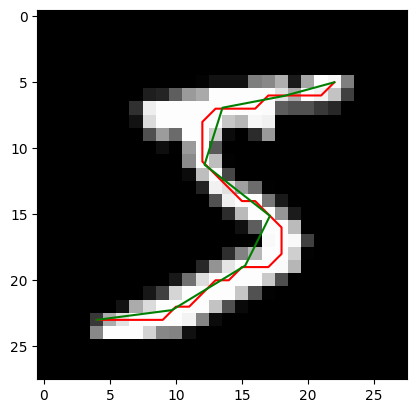

40
(8, 2)


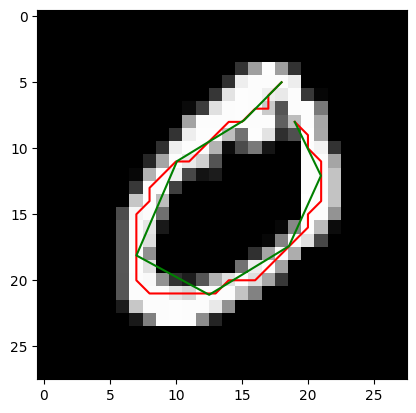

31
(8, 2)


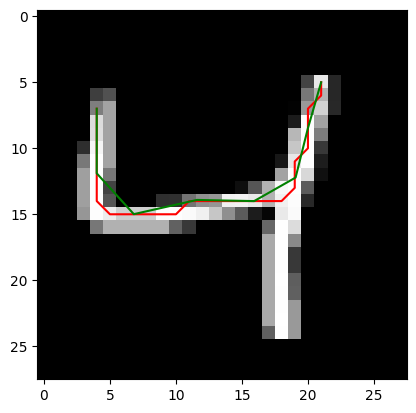

18
(8, 2)


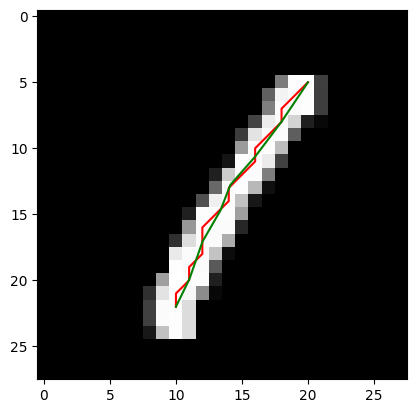

25
(8, 2)


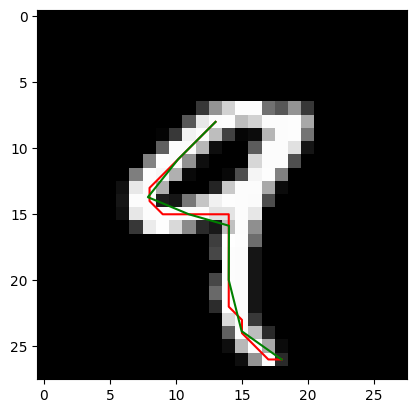

31
(8, 2)


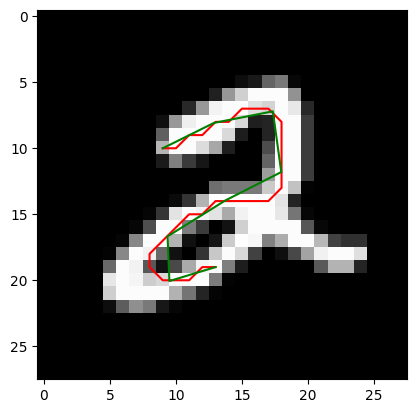

19
(8, 2)


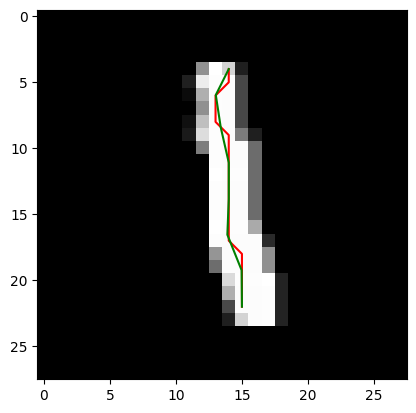

35
(8, 2)


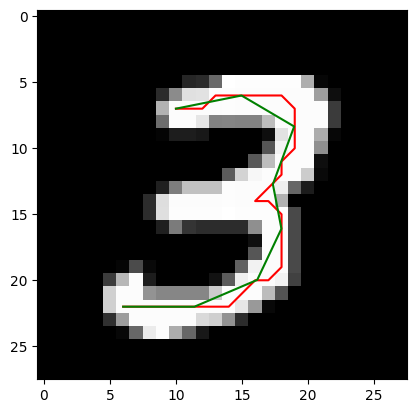

18
(8, 2)


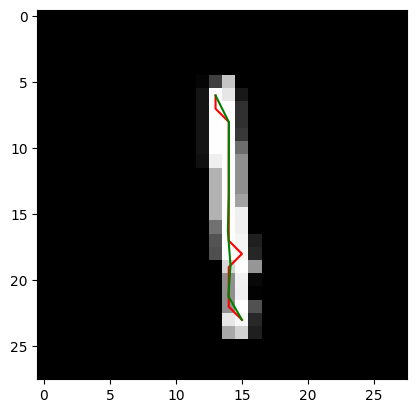

24
(8, 2)


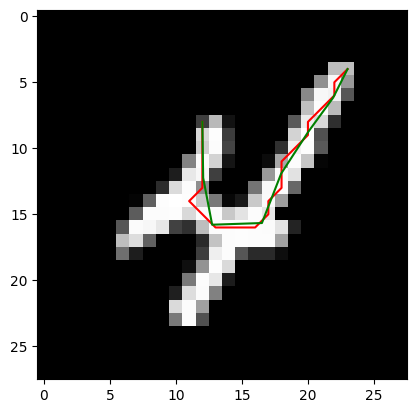

24
(8, 2)


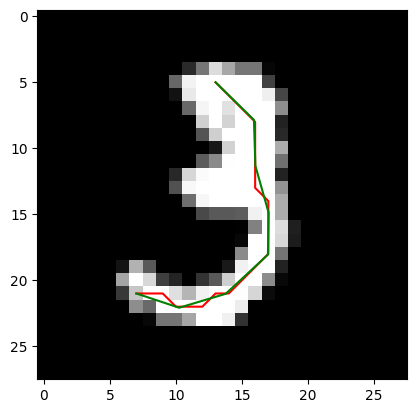

24
(8, 2)


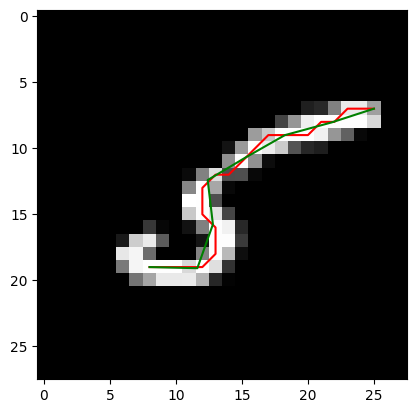

In [4]:
n_images = 12
images = []
init_splines = []
for i in range(n_images):
    img = dat[i, 1:].reshape(28, 28)
    img = img / 255.0
    images.append(img)
    path = get_splines_from_frame(img, 0.1)[0][:, ::-1]
    print(len(path))
    init_spline = np.array(path).astype(np.float32)
    init_spline = downsample_points(init_spline)
    init_splines.append(init_spline[None])
    print(init_spline.shape)
    plt.imshow(img, cmap='gray')
    plt.plot(path[:, 0], path[:, 1], 'r-')
    plt.plot(init_spline[:, 0], init_spline[:, 1], 'g-')
    plt.show()

In [5]:
images = jnp.array(images)

In [6]:
init_splines = jnp.array(init_splines) / 28

In [7]:
# model = SplenderImage(random.PRNGKey(0), init_splines, res = 28)
model = SplenderImage()

In [8]:
model = model.init(random.PRNGKey(0), init_knots=init_splines, res=28)

In [9]:
model.res

28

In [10]:
model.loc_params

Array([[[[-2.5586352e-02, -7.0034772e-02,  5.0000000e+00]]],


       [[[ 1.7338836e-01, -2.3418728e-01,  5.0000000e+00]]],


       [[[-2.5235909e-01, -4.8587483e-01,  5.0000000e+00]]],


       [[[ 5.2368335e-02, -4.6929926e-02,  5.0000000e+00]]],


       [[[-1.6912299e-01,  5.2752364e-01,  5.0000000e+00]]],


       [[[-1.7088041e-01, -1.0204202e-01,  5.0000000e+00]]],


       [[[ 5.1566195e-03, -2.4150580e-01,  5.0000000e+00]]],


       [[[-9.4756484e-05,  4.7001883e-02,  5.0000000e+00]]],


       [[[ 1.0294300e-03,  1.1775087e-01,  5.0000000e+00]]],


       [[[ 4.9110910e-01, -6.0251713e-01,  5.0000000e+00]]],


       [[[-4.8737362e-02,  1.7331626e-01,  5.0000000e+00]]],


       [[[ 3.1616157e-01, -2.1307448e-01,  5.0000000e+00]]]],      dtype=float32)

In [11]:
ims, lengths, curvatures = model()

In [12]:
ims

Array([[[0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5],
        [0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5],
        [0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5],
        ...,
        [0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5],
        [0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5],
        [0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5]],

       [[0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5],
        [0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5],
        [0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5],
        ...,
        [0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5],
        [0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5],
        [0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5]],

       [[0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5],
        [0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5],
        [0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5],
        ...,
        [0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5],
        [0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5],
        [0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5]],

       ...,

       [[0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5],
        [0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5],
        [0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5

In [13]:
model.loc_params

Array([[[[-2.5586352e-02, -7.0034772e-02,  5.0000000e+00]]],


       [[[ 1.7338836e-01, -2.3418728e-01,  5.0000000e+00]]],


       [[[-2.5235909e-01, -4.8587483e-01,  5.0000000e+00]]],


       [[[ 5.2368335e-02, -4.6929926e-02,  5.0000000e+00]]],


       [[[-1.6912299e-01,  5.2752364e-01,  5.0000000e+00]]],


       [[[-1.7088041e-01, -1.0204202e-01,  5.0000000e+00]]],


       [[[ 5.1566195e-03, -2.4150580e-01,  5.0000000e+00]]],


       [[[-9.4756484e-05,  4.7001883e-02,  5.0000000e+00]]],


       [[[ 1.0294300e-03,  1.1775087e-01,  5.0000000e+00]]],


       [[[ 4.9110910e-01, -6.0251713e-01,  5.0000000e+00]]],


       [[[-4.8737362e-02,  1.7331626e-01,  5.0000000e+00]]],


       [[[ 3.1616157e-01, -2.1307448e-01,  5.0000000e+00]]]],      dtype=float32)

In [14]:
model

SplenderImage(brush_profile=Array([1.        , 0.69444454, 0.4444444 , 0.25      , 0.11111107,
       0.02777776, 0.        , 0.0277778 , 0.11111113, 0.25      ,
       0.44444454, 0.69444454, 1.        ], dtype=float32), spline_contrast=Array([1.], dtype=float32), spline_brightness=Array([0.], dtype=float32), loc_params=Array([[[[-2.5586352e-02, -7.0034772e-02,  5.0000000e+00]]],


       [[[ 1.7338836e-01, -2.3418728e-01,  5.0000000e+00]]],


       [[[-2.5235909e-01, -4.8587483e-01,  5.0000000e+00]]],


       [[[ 5.2368335e-02, -4.6929926e-02,  5.0000000e+00]]],


       [[[-1.6912299e-01,  5.2752364e-01,  5.0000000e+00]]],


       [[[-1.7088041e-01, -1.0204202e-01,  5.0000000e+00]]],


       [[[ 5.1566195e-03, -2.4150580e-01,  5.0000000e+00]]],


       [[[-9.4756484e-05,  4.7001883e-02,  5.0000000e+00]]],


       [[[ 1.0294300e-03,  1.1775087e-01,  5.0000000e+00]]],


       [[[ 4.9110910e-01, -6.0251713e-01,  5.0000000e+00]]],


       [[[-4.8737362e-02,  1.7331626e-01,  5.00

In [15]:
@jit
def loss(model, images):
    recon, lengths, curvatures = model()
    recon_loss = jnp.mean((images - recon) ** 2)
    min_scale_knots = jax.nn.sigmoid((model.loc_params + model.knot_params)[..., 2]).min(axis = -1)
    # jax.debug.print("min_scale_knots: {min_scale_knots}", min_scale_knots=min_scale_knots)
    scale_multiplier_reg = 1e-3 * ((min_scale_knots - 1.0)**2).mean()
    return recon_loss + scale_multiplier_reg

def make_step(model, images, opt_state):
    loss_value, grads = value_and_grad(loss)(model, images)
    # grads = grad(loss)(model, images)
    # jax.debug.print("loss: {loss_value}", loss_value=loss_value)
    # jax.debug.print("grads: {grads}", grads=grads)
    updates, opt_state = optim.update(grads, opt_state, model)
    model = optax.apply_updates(model, updates)
    return model, opt_state, loss_value

In [16]:
model.loc_params

Array([[[[-2.5586352e-02, -7.0034772e-02,  5.0000000e+00]]],


       [[[ 1.7338836e-01, -2.3418728e-01,  5.0000000e+00]]],


       [[[-2.5235909e-01, -4.8587483e-01,  5.0000000e+00]]],


       [[[ 5.2368335e-02, -4.6929926e-02,  5.0000000e+00]]],


       [[[-1.6912299e-01,  5.2752364e-01,  5.0000000e+00]]],


       [[[-1.7088041e-01, -1.0204202e-01,  5.0000000e+00]]],


       [[[ 5.1566195e-03, -2.4150580e-01,  5.0000000e+00]]],


       [[[-9.4756484e-05,  4.7001883e-02,  5.0000000e+00]]],


       [[[ 1.0294300e-03,  1.1775087e-01,  5.0000000e+00]]],


       [[[ 4.9110910e-01, -6.0251713e-01,  5.0000000e+00]]],


       [[[-4.8737362e-02,  1.7331626e-01,  5.0000000e+00]]],


       [[[ 3.1616157e-01, -2.1307448e-01,  5.0000000e+00]]]],      dtype=float32)

In [17]:
optim = optax.adam(1e-2)
losses = []
opt_state = optim.init(model)
for step in range(1000):
    model, opt_state, loss_value = make_step(model, images, opt_state)
    losses.append(loss_value)

In [18]:
# optim = optax.adam(1e-4)
# opt_state = optim.init(model)
# for step in range(1):
#     model, opt_state, loss_value = make_step(model, images, opt_state)
#     # model_s, opt_state, loss_value = make_step(model, images, opt_state, filter_splines)
#     # losses.append(loss_value)

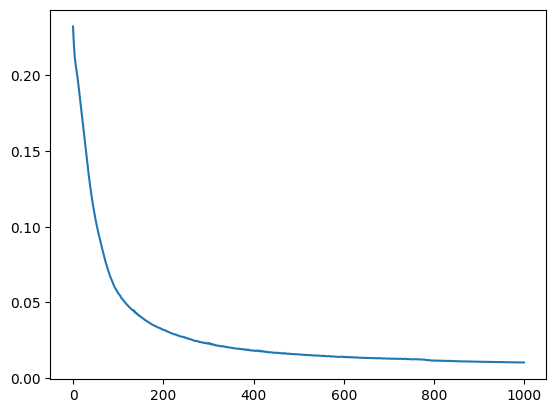

In [19]:
plt.plot(losses)
# plt.ylim(0.0665, 0.0668)

In [20]:
ims, lengths, curvatures = model()

In [21]:
print("model.loc_params", model.loc_params)
print("model.knot_params", model.knot_params)
print("model.global_scale", model.global_scale)
print("model.brush_profile", model.brush_profile)
print("model.kernel", model.kernel)
print("model.opacity", model.opacity)

model.loc_params [[[[-1.4266323e-01 -8.9778043e-02  2.4332170e+00]]]


 [[[ 5.6179490e-02 -2.4241279e-01  2.5550191e+00]]]


 [[[-2.5941366e-01 -2.2923680e-01  1.9977918e+00]]]


 [[[ 7.5162493e-02 -8.7311208e-02  2.6956754e+00]]]


 [[[ 2.3667376e-02  2.7284020e-01  2.2075713e+00]]]


 [[[-2.1828334e-01  1.0315414e-03  2.2542791e+00]]]


 [[[ 6.1462048e-02 -7.6180726e-02  3.3217423e+00]]]


 [[[-2.5674364e-01  1.3630959e-01  2.8979850e+00]]]


 [[[ 3.3361118e-03  9.3115456e-02  2.5430596e+00]]]


 [[[ 2.7274045e-01 -4.0216771e-01  2.7948570e+00]]]


 [[[-1.5286109e-01  2.7867511e-01  3.6066232e+00]]]


 [[[ 1.8461853e-01 -1.9502114e-01  2.0959949e+00]]]]
model.knot_params [[[[ 1.5628282e+00 -1.3513472e+00 -3.7170877e+00]
   [ 1.4800520e-01 -1.0051634e+00  3.1894412e+00]
   [-6.7654032e-01 -8.5137713e-01  3.0651531e+00]
   [-3.5695103e-01 -7.8053874e-01 -2.3564830e+00]
   [ 1.6101274e-01  7.3897112e-03 -2.9829485e+00]
   [ 7.8897190e-01  5.1022857e-01 -1.5274864e-01]
   [-3.7856445e-01

In [22]:
ims.shape

(12, 28, 28)

In [29]:
model.loc_params.shape

(12, 1, 1, 3)

In [32]:
xy_splines = [model.fit_spline(model.loc_params[i, 0] + model.knot_params[i, 0])[:2] for i in range(12)]

In [34]:
xy_splines[0]

(Interpolator1D(
   x=f32[8],
   f=f32[8],
   derivs={'fx': f32[8]},
   method='cubic2',
   extrap=False,
   period=None,
   axis=0
 ),
 Interpolator1D(
   x=f32[8],
   f=f32[8],
   derivs={'fx': f32[8]},
   method='cubic2',
   extrap=False,
   period=None,
   axis=0
 ))

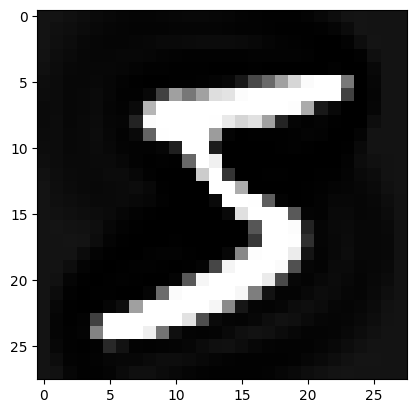

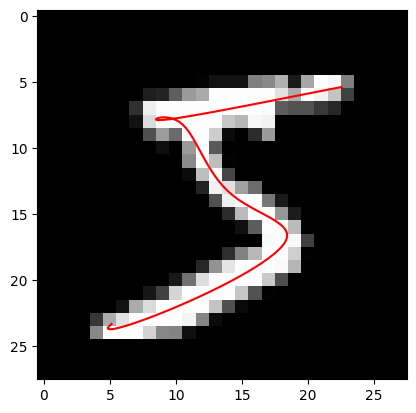

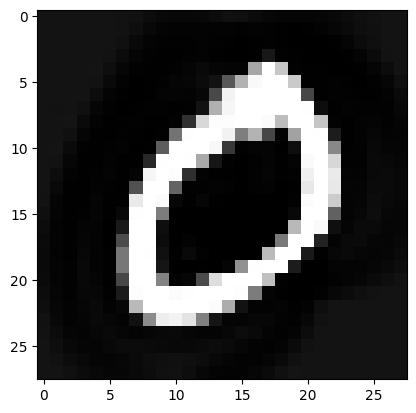

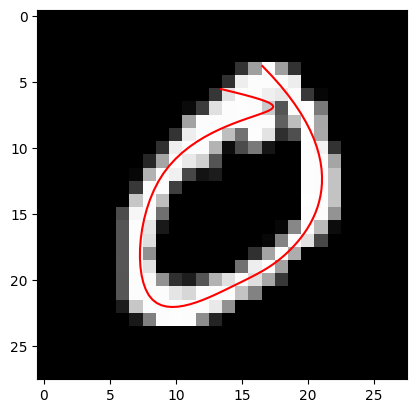

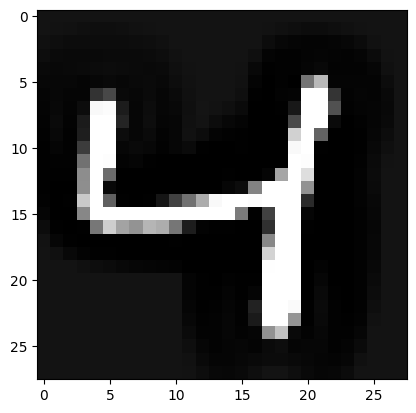

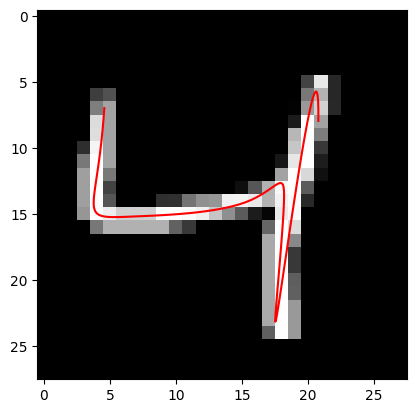

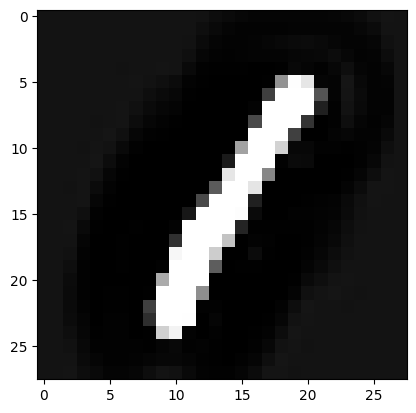

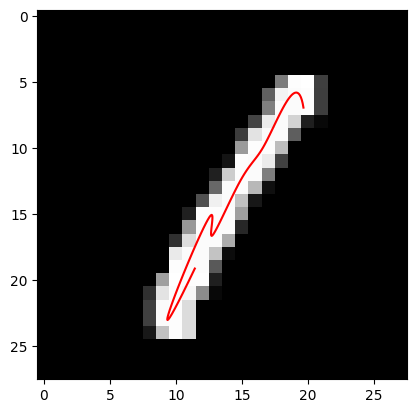

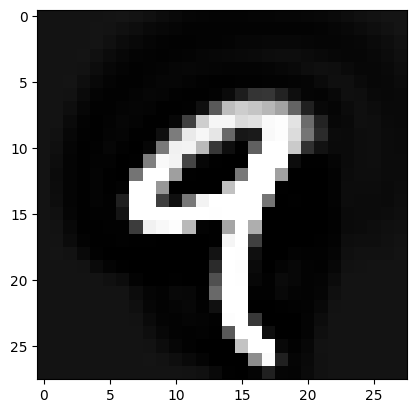

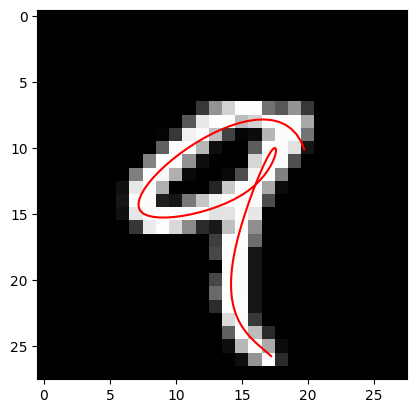

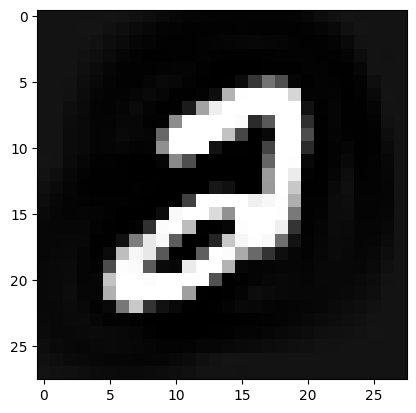

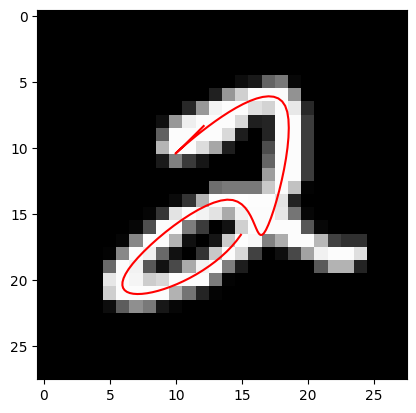

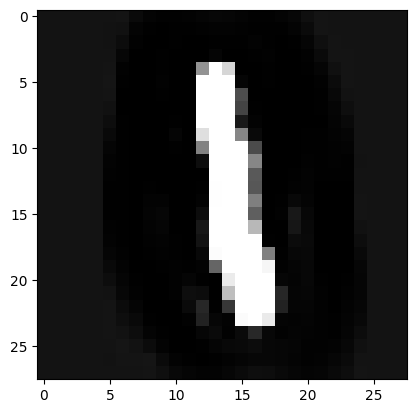

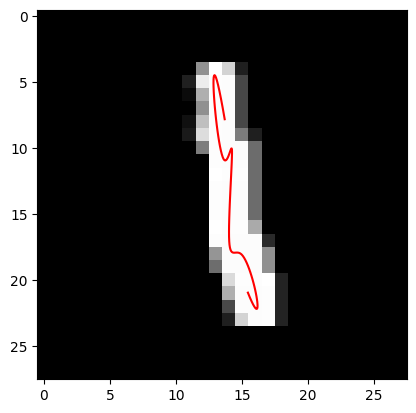

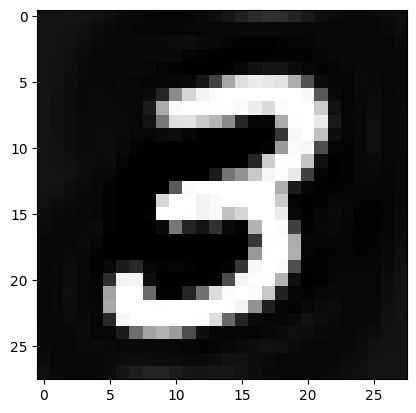

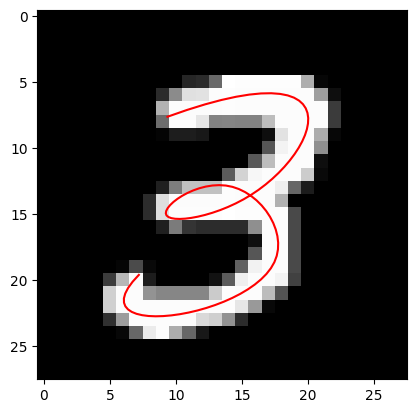

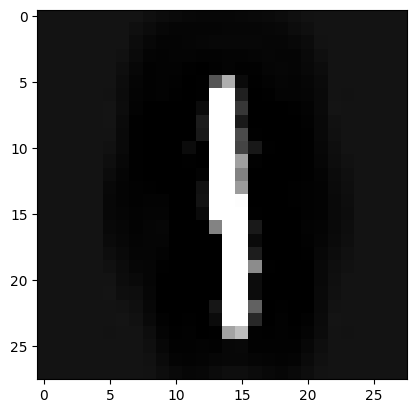

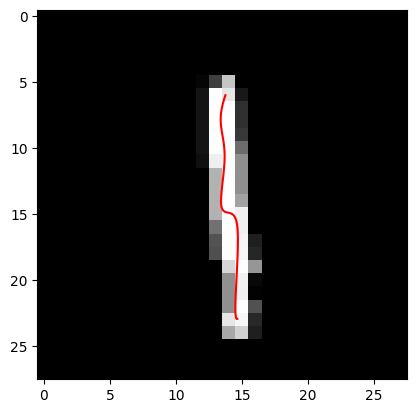

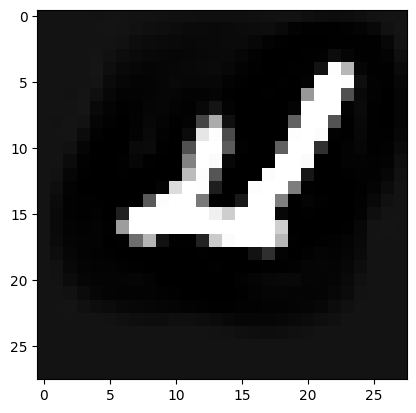

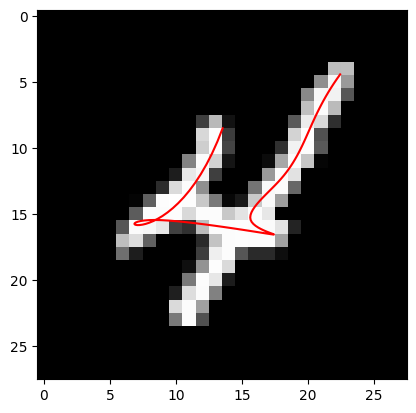

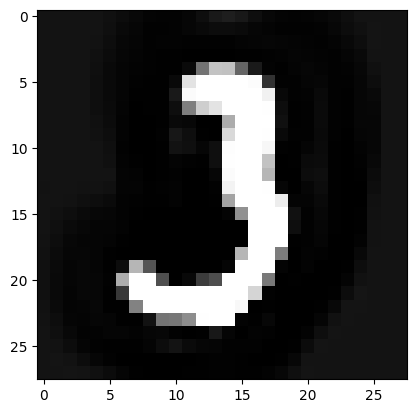

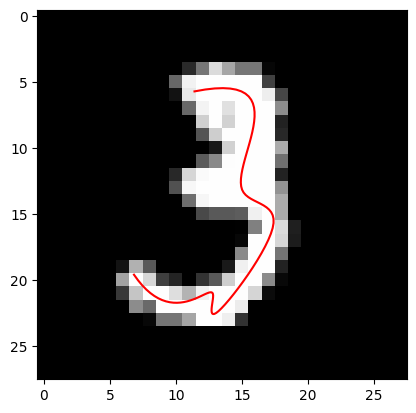

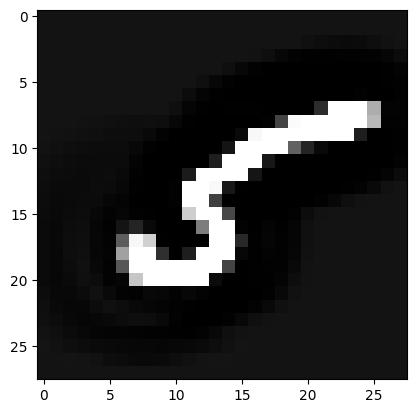

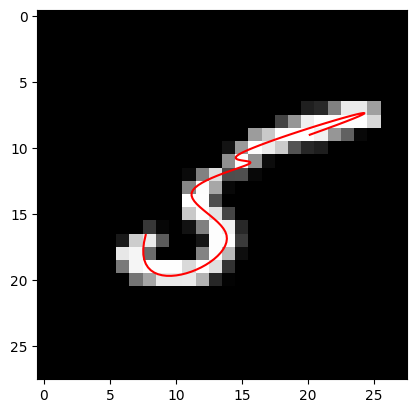

In [39]:
for i in range(n_images):
    plt.imshow(ims[i], cmap='gray', vmin=0, vmax=1)
    plt.show()
    plt.imshow(images[i], cmap='gray', vmin=0, vmax=1)
    plt.plot(model.res * xy_splines[i][0](jnp.linspace(0, 1, 100)), model.res * xy_splines[i][1](jnp.linspace(0, 1, 100)), c='r')
    plt.show()